In [ ]:
%matplotlib inline


# Estimating prediction intervals of time series forecast
This example uses :class:`~mapie.regression.MapieRegressor` to estimate
prediction intervals associated with time series forecast. We use the
standard cross-validation approach to estimate conformity scores and associated
prediction intervals.

We use here the Victoria electricity demand dataset used in the book
"Forecasting: Principles and Practice" by R. J. Hyndman and G. Athanasopoulos.
The electricity demand features daily and weekly seasonalities and is impacted
by the temperature, considered here as a exogeneous variable.

The data is modelled by a Random Forest model with a
:class:`~sklearn.model_selection.RandomizedSearchCV` using a sequential
:class:`~sklearn.model_selection.TimeSeriesSplit` cross validation, in which
the training set is prior to the validation set.
The best model is then feeded into :class:`~mapie.regression.MapieRegressor`
to estimate the associated prediction intervals.
We consider the standard CV+ resampling method.

We wish to emphasize one main limitation with this example.
We use a standard cross-validation in Mapie to estimate the prediction
intervals, through the `sklearn.model_selection.KFold()` object.
Residuals are therefore estimated using models trained on data with higher
indices than the validation data, which is inappropriate for time-series data.
However, using a `sklearn.model_selection.TimeSeriesSplit` cross validation
object for estimating the residuals breaks the theoretical guarantees of the
Jackknife+ and CV+ methods.


In [2]:
!pip install skforecast

In [3]:

from skforecast.datasets import fetch_dataset

In [4]:
import pandas as pd
from matplotlib import pylab as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from mapie.metrics import (regression_coverage_score,
                           regression_mean_width_score)
from mapie.regression import MapieRegressor

In [8]:
demand_df.Date.dt.hour

0        0
1        0
2        0
3        0
4        0
        ..
52603    0
52604    0
52605    0
52606    0
52607    0
Name: Date, Length: 52608, dtype: int32

In [9]:
data = fetch_dataset(name='vic_electricity', raw=True)
# Load input data and feature engineering
demand_df = data.copy()
demand_df["Date"] = pd.to_datetime(demand_df.index)
demand_df["Weekofyear"] = demand_df.Date.dt.isocalendar().week.astype("int64")
demand_df["Weekday"] = demand_df.Date.dt.isocalendar().day.astype("int64")
demand_df["Hour"] = demand_df.Date.dt.hour

# Train/validation/test split
num_test_steps = 24 * 7 * 2
demand_train = demand_df.iloc[:-num_test_steps, :].copy()
demand_test = demand_df.iloc[-num_test_steps:, :].copy()
X_train = demand_train.loc[:, ["Weekofyear", "Weekday", "Hour", "Temperature"]]
y_train = demand_train["Demand"]
X_test = demand_test.loc[:, ["Weekofyear", "Weekday", "Hour", "Temperature"]]
y_test = demand_test["Demand"]

vic_electricity
---------------
Half-hourly electricity demand for Victoria, Australia
O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse
Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,
https://github.com/tidyverts/tsibbledata/.
https://tsibbledata.tidyverts.org/reference/vic_elec.html
Shape of the dataset: (52608, 5)


In [10]:
# CV parameter search
n_iter = 10
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
random_state = 59
rf_model = RandomForestRegressor(random_state=random_state)
rf_params = {"max_depth": randint(2, 30), "n_estimators": randint(10, 1e3)}
cv_obj = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_params,
    n_iter=n_iter,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    random_state=random_state,
    verbose=0,
    n_jobs=-1,
)
cv_obj.fit(X_train, y_train)
best_est = cv_obj.best_estimator_

In [12]:
best_est

RandomForestRegressor(max_depth=5, n_estimators=330, random_state=59)

In [13]:
demand_test

,Time,Demand,Temperature,Date,Holiday,Weekofyear,Weekday,Hour
52272,2014-12-24T13:00:00Z,4042.475124,16.4,1970-01-01 00:00:00.000052272,True,1,4,0
52273,2014-12-24T13:30:00Z,4052.929622,16.4,1970-01-01 00:00:00.000052273,True,1,4,0
52274,2014-12-24T14:00:00Z,3820.781824,16.2,1970-01-01 00:00:00.000052274,True,1,4,0
52275,2014-12-24T14:30:00Z,3623.967590,16.1,1970-01-01 00:00:00.000052275,True,1,4,0
52276,2014-12-24T15:00:00Z,3470.302766,15.8,1970-01-01 00:00:00.000052276,True,1,4,0
...,...,...,...,...,...,...,...,...
52603,2014-12-31T10:30:00Z,3873.448714,19.0,1970-01-01 00:00:00.000052603,False,1,4,0
52604,2014-12-31T11:00:00Z,3791.637322,18.5,1970-01-01 00:00:00.000052604,False,1,4,0
52605,2014-12-31T11:30:00Z,3724.835666,17.7,1970-01-01 00:00:00.000052605,False,1,4,0
52606,2014-12-31T12:00:00Z,3761.886854,17.3,1970-01-01 00:00:00.000052606,False,1,4,0


/workspaces/Predicoes_macroeconomicas/variaveis_economicas/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


Coverage and prediction interval width mean for CV+: 0.780, 2458.790


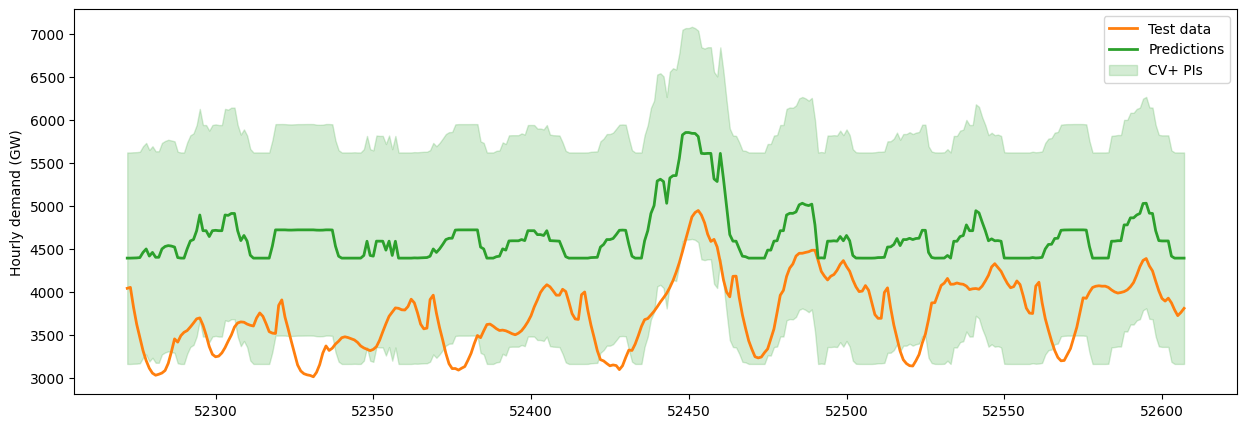

In [11]:

# Estimate prediction intervals on test set with best estimator
# Here, a non-nested CV approach is used for the sake of computational
# time, but a nested CV approach is preferred.
# See the dedicated example in the gallery for more information.
alpha = 0.1
mapie = MapieRegressor(
    best_est, method="plus", cv=n_splits, agg_function="median", n_jobs=-1
)
mapie.fit(X_train, y_train)
y_pred, y_pis = mapie.predict(X_test, alpha=alpha)
coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])

# Print results
print(
    "Coverage and prediction interval width mean for CV+: "
    f"{coverage:.3f}, {width:.3f}"
)

# Plot estimated prediction intervals on test set
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel("Hourly demand (GW)")
ax.plot(demand_test.Demand, lw=2, label="Test data", c="C1")
ax.plot(demand_test.index, y_pred, lw=2, c="C2", label="Predictions")
ax.fill_between(
    demand_test.index,
    y_pis[:, 0, 0],
    y_pis[:, 1, 0],
    color="C2",
    alpha=0.2,
    label="CV+ PIs",
)
ax.legend()
plt.show()